overall, using K's architecture instead of local PCN, we can achieve same type qualitative conclusions: more cycles -> better performance.

In [1]:
from sys import path
from os.path import relpath, realpath, abspath, join, exists
from itertools import product, chain

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py

pd.set_option('display.max_rows', 999)

In [2]:
from torchnetjson.builder import build_net

In [3]:
from thesis_v2 import dir_dict
from thesis_v2.data import load_data_helper
from thesis_v2.training.training_aux import load_training_results
# I forgot how this count_params handles BN buffer parameters (running mean and std) looks like it's ignored.
from thesis_v2.training_extra.misc import count_params
from thesis_v2.models.maskcnn_polished_with_rcnn_k_bl.builder import load_modules

load_modules()

In [4]:
from thesis_v2.configs.model.maskcnn_polished_with_rcnn_k_bl import (
    explored_models_20200218 as param_iterator_obj,
    explored_models_20200430 as param_iterator_obj_smaller_training_data,
    explored_models_20200520 as param_iterator_obj_more_cls,
    explored_models_20200616 as param_iterator_obj_even_more_cls,
    keygen
)

In [5]:
# compute ccmax
from strflab.stats import cc_max
from thesis_v2.data.prepared.yuanyuan_8k import get_neural_data_per_trial

cc_max_all_neurons = cc_max(get_neural_data_per_trial(
    ('042318', '043018','051018',))
                           )
assert cc_max_all_neurons.shape == (79,)

In [6]:
def load_everything():
    _df_collect = []
    for idx, param in enumerate(
        chain(
            param_iterator_obj().generate(),
            param_iterator_obj_smaller_training_data().generate(),
            param_iterator_obj_more_cls().generate(),
            param_iterator_obj_even_more_cls().generate(),
        )
    ):
        if idx % 100 == 0:
            print(idx)
            
#         if idx >= 100:
#             break
            
#         print(len(param))
#         print(len(param))

        if param['kernel_size_l23'] != 3:
            continue

        if len(param) == 22:
            param['train_keep'] = None
        assert len(param) == 23
        
        assert param['kernel_size_l1'] == 9
        assert param['ff_1st_block']
        
        
        
        assert param['split_seed'] == 'legacy'
        assert param['pooling_ksize'] == 3
        assert param['pooling_type'] == 'avg'
        assert not param['bn_after_fc']
        assert param['rcnn_bl_psize'] == 1
        assert param['rcnn_bl_ptype'] is None
        assert param['input_size'] == 50
        
        # 12 to go
        # remove smoothness_name and scale_name, 10 to go
        
#         assert param['model_seed'] == 0
        
        key = keygen(**{k: v for k, v in param.items() if k not in {'scale', 'smoothness'}})
        # 10 to go.
        result = load_training_results(key, return_model=False)
        # load twice, first time to get the model.
        result = load_training_results(key, return_model=True, model=build_net(result['config_extra']['model']))
        num_epochs = [len(x) for x in result['stats_all']]
        
        cc_raw = np.asarray(result['stats_best']['stats']['test']['corr'])
        assert cc_raw.shape == (79,)
        
        if param['train_keep'] is None:
            param['train_keep'] = 5120
        
        _df_collect.append(
            {
                'train_keep': param['train_keep'],
                'act_fn': param['act_fn'],
                'loss_type': param['loss_type'],
                'scale': float(param['scale']),
                'smoothness': float(param['smoothness']),
                'num_layer': param['num_layer'],
                'out_channel': param['out_channel'],
                # 4 to go.
                '1st_bn_before_act': param['ff_1st_bn_before_act'],
                'rcnn_bl_cls': param['rcnn_bl_cls'],
                'rcnn_acc_type': param['rcnn_acc_type'],

                'model_seed': param['model_seed'],
                # done,
                'corr_test': ((cc_raw/cc_max_all_neurons)**2).mean(),
                'max_epoch': max(num_epochs),
                'num_param': count_params(result['model']),
            }
        )
    _df =  pd.DataFrame(_df_collect, columns=[
#             'split_seed',
        'train_keep',
        'act_fn',
        'loss_type', 'scale', 'smoothness', 'num_layer',
        'out_channel', '1st_bn_before_act',

        'rcnn_bl_cls',
#         'rcnn_acc_type',
        'model_seed',

        'corr_test',
        'num_param',
        'max_epoch',
    ])
#     print(_df)
    _df = _df.set_index([
        'train_keep',
        'act_fn',
        'loss_type', 'scale', 'smoothness', 'num_layer',
        'out_channel', '1st_bn_before_act',
        'rcnn_bl_cls',
#         'rcnn_acc_type',
        'model_seed',
    ], verify_integrity=True)
    return _df

In [7]:
df = load_everything()

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000


In [8]:
corr_mean = df['corr_test'].unstack('model_seed').mean(axis=1)

# mean, max, min, all the same. for num_param
num_param = df['num_param'].unstack('model_seed').mean(axis=1)

In [9]:
# let's try to quickly eliminate bad configs, just like before, by plotting scatter plots.
def scatter(x, y, xlabel, ylabel, title):
    plt.close('all')
    plt.figure(figsize=(6, 5))
    plt.scatter(x, y, s=1)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.axis('equal')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.plot([0,1],[0,1],linestyle='--')
    plt.title(title)
    plt.show()
    print('y-x mean', (y-x).mean(), 'y-x>0 mean', ((y-x)>0).mean())
    print('y top', y.max(), 'x top', x.max())

In [10]:
# here, I need to check the effective ness of act_fn, bn_before_act, bn_after_fc, loss_type
def check_compare_one_case(series_in, label_to_unstack, values_to_check=None):
    df_unstacked = series_in.unstack(label_to_unstack)
#     assert df_unstacked.shape[1] == 2
    if values_to_check is None:
        values_to_check = df_unstacked.columns.values[:2].tolist()
    else:
        pass
    
    assert len(values_to_check) == 2
    label_x = values_to_check[0]
    label_y = values_to_check[1]
        
    data_x = df_unstacked.loc[:,label_x].values
    data_y = df_unstacked.loc[:,label_y].values
    
    
    
    scatter(data_x, data_y, str(label_x), str(label_y), f'{label_to_unstack}: {label_y} vs {label_x}')

(48, 10)
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
n 48
2 - 1 mean 0.029584268475115222 sem 0.0023691908064684014
3 - 2 mean 0.005058711595277207 sem 0.0011520950345487745
4 - 3 mean 0.002843366782809708 sem 0.0008682186522390155
4 - 2 mean 0.007902078378086916 sem 0.0013188904547508022


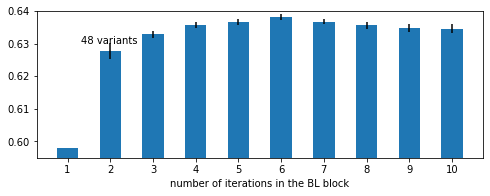

[0.5981444926019676, 0.6277287610770829, 0.63278747267236, 0.6356308394551697, 0.6364964820075983, 0.6381282988395233, 0.636692609321775, 0.6356026393465307, 0.6348428626016055, 0.6345055366352274] [ 4.946007    0.80587539  0.44933993  0.13618637  0.25637484 -0.22498446
 -0.1711925  -0.11953644 -0.05313535]


,num_of_cycles,performance,gain %
0,1,0.598144,NaN
1,2,0.627729,4.946007
2,3,0.632787,0.805875
3,4,0.635631,0.449340
4,5,0.636496,0.136186
5,6,0.638128,0.256375
6,7,0.636693,-0.224984
7,8,0.635603,-0.171192
8,9,0.634843,-0.119536
9,10,0.634506,-0.053135


In [11]:
def plot_step_increase(df_this, pairs_to_check, ylim):
    # remove those no innner act ones.
    df_unstacked = df_this.unstack('rcnn_bl_cls')
#     df_unstacked = corr_mean.unstack('pcn_cls')
    print(df_unstacked.shape)
    
#     selector = df_unstacked.values[:,0] >= 0.50
    selector = ()
#     print(selector.mean())
    
    cls_values = df_unstacked.columns.values.tolist()
    print(cls_values)
    assert cls_values == list(range(1,len(cls_values)+1))
    
    n = df_unstacked.shape[0]
    
#     n = selector.sum()
    print('n', n)
    
    
    for p1, p2 in pairs_to_check:
        val0 = df_unstacked.values[:,p1-1][selector]
        val1 = df_unstacked.values[:,p2-1][selector]

        # selection
        print(
            f'{p2} - {p1}',
            'mean', (val1-val0).mean(),
            'sem', (val1-val0).std()/np.sqrt(n)
        )
        
    # time to plot.
    # show results for cls_values[0] through cls_values[-1]
    # for the first one, just show mean,
    # for others show mean and s.e.m. of increase.
    
    mean_performance = []
    sem_increase = []
    labels = []
    
    for idx, cls_name in enumerate(cls_values):
        assert idx == cls_name - 1
        mean_performance.append(df_unstacked.values[:,idx][selector].mean())
        if idx == 0:
            sem_increase.append(0.0)
        else:
            sem_increase.append((df_unstacked.values[:,idx][selector]-df_unstacked.values[:,idx-1][selector]).std()/np.sqrt(n))
        labels.append(str(cls_name))
        
    
    plt.close('all')
    fig = plt.figure(figsize=(8,3))
    plt.bar(np.arange(len(cls_values)), mean_performance, 0.5, yerr=sem_increase)
#     plt.ylabel('neural prediction performance')
    plt.ylim(*ylim)
    plt.xlabel('number of iterations in the BL block')
    plt.xticks(np.arange(len(cls_values)), labels)
    
    
    plt.text(0.1, 0.8, f'{n} variants', verticalalignment='center', horizontalalignment='left', transform=plt.gca().transAxes)
    fig.subplots_adjust(bottom=0.2)

    plt.show()
    
    print(mean_performance, np.diff(mean_performance)/mean_performance[:-1]*100)
    
    return pd.DataFrame(
        data = {
            'num_of_cycles': cls_values,
            'performance': mean_performance,
            'gain %': np.concatenate([np.asarray([np.nan]),  np.diff(mean_performance)/mean_performance[:-1]*100])
        },
        columns = ['num_of_cycles', 'performance', 'gain %']
    )
    
    
    
# trend for 0-1-2 is good. then bad.
plot_step_increase(corr_mean.xs(5120, level='train_keep'), [(1,2),(2,3),(3,4),(2,4)], (0.595, 0.64))

(48, 10)
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
n 48
2 - 1 mean 0.03213541874850471 sem 0.0025766177900937983
3 - 2 mean 0.008347088783902957 sem 0.0015108716698198836
4 - 3 mean 0.0018157022521956047 sem 0.0011304202308431818
4 - 2 mean 0.01016279103609856 sem 0.0017724249861233421


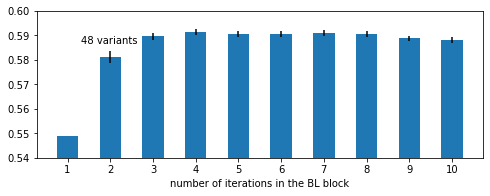

[0.5490784455163847, 0.5812138642648894, 0.5895609530487924, 0.591376655300988, 0.5904544316274594, 0.5907049231374611, 0.590807603380315, 0.5907289117768241, 0.5888142268133377, 0.5879780295417077] [ 5.85260977  1.43614757  0.30797532 -0.15594523  0.04242351  0.01738266
 -0.01331933 -0.32412244 -0.14201377]


,num_of_cycles,performance,gain %
0,1,0.549078,NaN
1,2,0.581214,5.852610
2,3,0.589561,1.436148
3,4,0.591377,0.307975
4,5,0.590454,-0.155945
5,6,0.590705,0.042424
6,7,0.590808,0.017383
7,8,0.590729,-0.013319
8,9,0.588814,-0.324122
9,10,0.587978,-0.142014


In [12]:
plot_step_increase(corr_mean.xs(2560, level='train_keep'), [(1,2),(2,3),(3,4),(2,4)], (0.54, 0.60))

(48, 10)
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
n 48
2 - 1 mean 0.04523365574800469 sem 0.005037852949246889
3 - 2 mean 0.013131153779203972 sem 0.002878739887091527
4 - 3 mean 0.005734356768863336 sem 0.002358048753461559
4 - 2 mean 0.01886551054806731 sem 0.004194165900711485


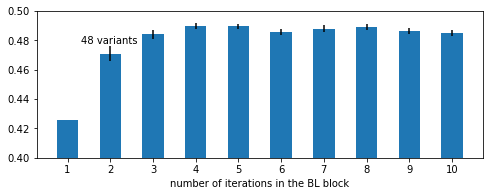

[0.425658276964285, 0.47089193271228974, 0.48402308649149367, 0.48975744326035703, 0.4894989677010478, 0.4856686831073271, 0.4878747808122899, 0.4891535687737521, 0.4865969489321256, 0.48492418069923104] [10.62675348  2.78857055  1.18472795 -0.05277624 -0.78249084  0.45423923
  0.26211397 -0.522662   -0.34376875]


,num_of_cycles,performance,gain %
0,1,0.425658,NaN
1,2,0.470892,10.626753
2,3,0.484023,2.788571
3,4,0.489757,1.184728
4,5,0.489499,-0.052776
5,6,0.485669,-0.782491
6,7,0.487875,0.454239
7,8,0.489154,0.262114
8,9,0.486597,-0.522662
9,10,0.484924,-0.343769


In [13]:
plot_step_increase(corr_mean.xs(1280, level='train_keep'), [(1,2),(2,3),(3,4),(2,4)], (0.4, 0.5))

In [14]:
# check relationship between num_param and performance, colored for different num_of_cycles.